# Who Sub-Modules?

A look at GitHub's most popular projects' use of `git submodule`. 

## How This Works 

This notebook analyzes the `git submodule` usage of GitHub's 1000 most-starred repositories. 

All data we examine is sourced from via GitHub's GraphQL API. 
The paired [script](./index.js) (written in NodeJS) grabs the most-popular repositories' 
information with queries along the lines of:

```graphql
{
      search(query: "stars:>1000 sort:stars", type: REPOSITORY, first: 10) {
        repositoryCount
        pageInfo {
            endCursor
            hasNextPage
          }
        edges {
          cursor
          
          node {
            ... on Repository {
              name
              url
              descriptionHTML
              languages(first: 10) {
                nodes {
                  name
                }
              }
              stargazers {
                totalCount
              }
              forks {
                totalCount
              }
              submodules {
                totalCount
              }
            }
          }
        }
      }
    }
```

Similar queries can be run on an interactive basis through 
GitHub's exposed [GraphQL Explorer](https://docs.github.com/en/graphql/overview/explorer)
(including the query above, pasted verbatim). 

While the `submodules { totalCount }` fragment is really the point here, 
we grab a handful of pieces of auxiliariy information, such as the 
languages each repository uses. 
It seems relatively likely that language-choice may impact the prevalence of sub-moduling. 

The data-collection script stores this repo-info in a pile of local JSON files, to be analyzed here. 
Our first batch of code munges the query-specific component (such as the pagination `cursors`, 
and labels of `nodes`), and creates our two primary pieces of data: 

* `submodule_counts`, a list of the submodule-counts 
* `submodule_users`, a list of repository-dictionaries with one or more git submodules


In [1]:
import matplotlib.pyplot as plt
import os, glob, json 
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
# Initial data munging 

def submodule_count(v: dict) -> int:
    return v["submodules"]["totalCount"]

submodule_counts = []
submodule_users = []

for fname in sorted(glob.glob('repos/repos.*.json'), key=os.path.getmtime):
    j = json.loads(open(fname, 'r').read())
    for v in j:
        cnt = submodule_count(v["node"])
        submodule_counts.append(cnt)
        if cnt: submodule_users.append(v['node'])

## Onto Data 

Now that we've got our data in hand, let's take a look at its histogram.

(array([992.,   3.,   2.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  0.,  14.,  28.,  42.,  56.,  70.,  84.,  98., 112., 126., 140.]),
 <BarContainer object of 10 artists>)

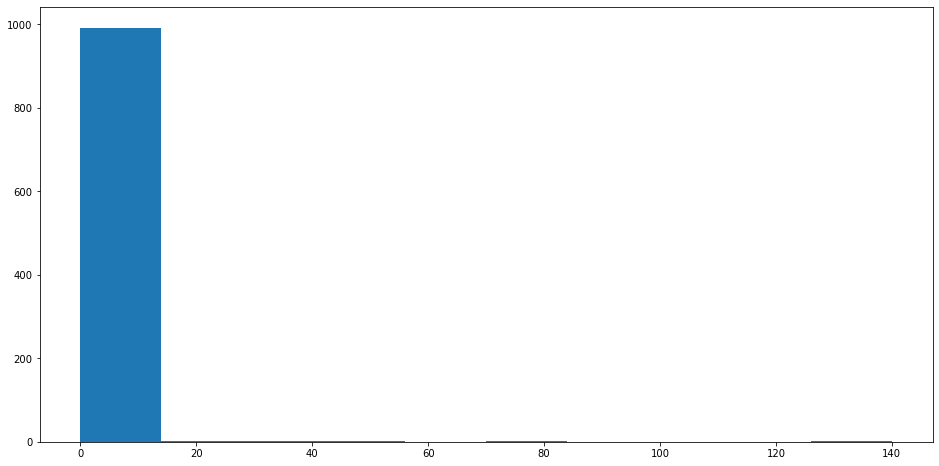

In [3]:
plt.hist(submodule_counts)

Probably unsurprisingly, the overwhelming majority of projects 
fall in the left-most bin, as they do not use `git submodule`. 

Given essentially all data falls into bin-zero, 
we're probably better off viewing a textual representation. 

In [4]:
def dict_hist(d: list) -> dict:
    """ Create a 'histogram dictionary' of prevelance of occurances in list `d`. """
    rv = {}
    for i in d:
        if i in rv:
            rv[i] += 1
        else:
            rv[i] = 1
    return rv

h = dict_hist(submodule_counts)
for k in sorted(h.keys()):
    print(f'{k} : {h[k]}')

0 : 934
1 : 24
2 : 9
3 : 6
4 : 6
5 : 3
6 : 3
7 : 3
8 : 1
10 : 1
11 : 2
14 : 1
16 : 1
17 : 1
31 : 1
34 : 1
46 : 1
71 : 1
140 : 1



## Top-Line 

Of the top 1000 repositories, 934 (93.4%) don't use `git submodule`. 

## The Sub-Modulers 

Of the other 66 (6.6%) which do, 
the plurality (24/66) have a single submodule. 
Most of the remainder have a few, say between two and seven. 
A few repositories appear to be "super submodulers", including more than 15, 
in one case as many as 140(!). 
We'll generate some more visual range by filtering these super-modulers out. 


(array([33.,  6.,  6.,  6.,  3.,  1.,  1.,  2.,  0.,  1.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <BarContainer object of 10 artists>)

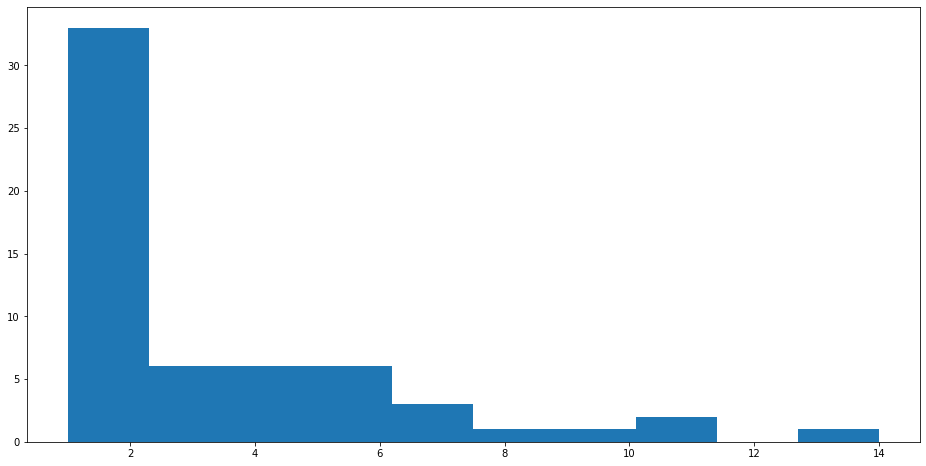

In [5]:
users_counts = [cnt for cnt in submodule_counts if cnt > 0]
plt.hist([cnt for cnt in users_counts if cnt > 0 and cnt < 15])


## The Few Super-Submodulers 

Now - who (or what) are these super-submodulers? 
What are they doing with all of them? 

In [6]:
super_supmodulers = [r for r in submodule_users if submodule_count(r) >= 15]
print(len(super_supmodulers))
super_supmodulers

7


[{'name': 'rust',
  'url': 'https://github.com/rust-lang/rust',
  'descriptionHTML': '<div>Empowering everyone to build reliable and efficient software.</div>',
  'languages': {'nodes': [{'name': 'Makefile'},
    {'name': 'Rust'},
    {'name': 'CSS'},
    {'name': 'Python'},
    {'name': 'Shell'},
    {'name': 'C'},
    {'name': 'C++'},
    {'name': 'JavaScript'},
    {'name': 'Puppet'},
    {'name': 'Pascal'}]},
  'stargazers': {'totalCount': 51343},
  'forks': {'totalCount': 7186},
  'submodules': {'totalCount': 16}},
 {'name': 'pytorch',
  'url': 'https://github.com/pytorch/pytorch',
  'descriptionHTML': '<div>Tensors and Dynamic neural networks in Python with strong GPU acceleration</div>',
  'languages': {'nodes': [{'name': 'CMake'},
    {'name': 'Python'},
    {'name': 'Shell'},
    {'name': 'Lua'},
    {'name': 'C++'},
    {'name': 'C'},
    {'name': 'Objective-C'},
    {'name': 'Cuda'},
    {'name': 'Vim script'},
    {'name': 'Batchfile'}]},
  'stargazers': {'totalCount': 4566

## What Do the Super-Sub-Modulers Have in Common? 

These seven super-users come from a variety of areas - 
machine learning, programming langauges and compilers, command-line tools, and databases. 
While it's not completely clear what drove these seven repositories to 
so heavily use submodules, a few commonalities stick out. 
Their `languages` lists have *a lot* of C and C++ - 
the two most popular languages which lack mature, widely-adopted package managers. 

The sole repository which essentially *solely* consists of git submodules isn't 
much of a git-project (or software project) at all - it's the [Darcula](https://github.com/dracula/dracula-theme) 
color-theme, which provides links to its language and application-specific 
implementations (e.g. [Darcula for Slack](https://github.com/dracula/slack/tree/15d6974817e2ed95036a938e6e3e857e761062c4), 
[Darcula for ZSH](https://github.com/dracula/zsh/tree/b0b8f90aa2bf8918ef9af32751b80b51b19a25c7)). 
Many of these are simply stored in GitHub as zip-files. 

## Take-Aways 

* `git submodule` is pretty rare among GitHub's most popular projects. About 6.6% of projects use it, and 0.7% make heavy use of 15 or more submodules. 
* This aligns with a common observation that `git submodule` information and documentation is generally aways more difficult to find than that of the remainder of `git`. 
* GitHub's sole popular "meta-repo", which includes solely `git submodule` links, isn't really a code repo at all, but a set of implementations of a popular color-theme. 

## Index: All of the Popular Sub-Module Users

We'll close with details on all the top-1000 repositories which use `git submodule`. 

These 66 projects share a fair amount with the super-sub-modulers, 
particularly in that C and C++ are prominent in their `languages` lists. 
(Google's ProtoBuf, PyTorch, and `git` itself all fall into this category.) 

The most popular is NodeJS author Ryan Dahl's Rust-based replacement, Deno. 
Its sub-module usage appears dedicated to its own continuous integration, 
including pre-compiler test data and a test suite. 

In [7]:
submodule_users

[{'name': 'deno',
  'url': 'https://github.com/denoland/deno',
  'descriptionHTML': '<div>A secure JavaScript and TypeScript runtime</div>',
  'languages': {'nodes': [{'name': 'TypeScript'},
    {'name': 'JavaScript'},
    {'name': 'Rust'},
    {'name': 'HTML'},
    {'name': 'C#'},
    {'name': 'PowerShell'}]},
  'stargazers': {'totalCount': 71610},
  'forks': {'totalCount': 3662},
  'submodules': {'totalCount': 3}},
 {'name': 'terminal',
  'url': 'https://github.com/microsoft/terminal',
  'descriptionHTML': '<div>The new Windows Terminal and the original Windows console host, all in the same place!</div>',
  'languages': {'nodes': [{'name': 'C#'},
    {'name': 'Batchfile'},
    {'name': 'PowerShell'},
    {'name': 'C++'},
    {'name': 'C'},
    {'name': 'Assembly'},
    {'name': 'Roff'},
    {'name': 'PHP'},
    {'name': 'Objective-C'},
    {'name': 'Python'}]},
  'stargazers': {'totalCount': 70983},
  'forks': {'totalCount': 6295},
  'submodules': {'totalCount': 2}},
 {'name': 'rust'